In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from pyramid.arima import auto_arima

from Sloth.Sloth import Sloth
Sloth = Sloth()

/home/jgleason/.local/lib/python3.5/site-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)
Using TensorFlow backend.


In [2]:
# read in different datasets

# electronic production data
data_electronic = pd.read_csv("datasets/Electronic_Production.csv",index_col=0)
data_electronic.index = pd.to_datetime(data_electronic.index)

# Beijing temperature data
data_temp = pd.read_csv("datasets/PRSA_data_2010.1.1-2014.12.31.csv",index_col=0)
data_temp = data_temp.groupby(['year', 'month']).mean()
data_temp = data_temp['TEMP']

# sunspots data
data_sun = pd.read_csv("datasets/learningData.csv",index_col=0)
data_sun = data_sun['sunspot.month'].dropna()
#index = [i for i in range(1700, 1700 + data_sun.shape[0])]
#data_sun.index = index
print(data_sun)


d3mIndex
49       58.0
50       62.6
51       70.0
52       55.7
53       85.0
54       83.5
55       94.8
56       66.3
57       75.9
58       75.5
59      158.6
60       85.2
61       73.3
62       75.9
63       89.2
64       88.3
65       90.0
66      100.0
67       85.4
68      103.0
69       91.2
70       65.7
71       63.3
72       75.4
73       70.0
74       43.5
75       45.3
76       56.4
77       60.7
78       50.7
        ...  
2839    143.8
2840    158.7
2841    167.3
2842    162.4
2843    137.5
2844    150.1
2845    111.2
2846    163.6
2847    153.8
2848    122.0
2849     82.2
2850    110.4
2851    106.1
2852    107.6
2853    118.8
2854     94.7
2855     98.1
2856    127.0
2857     84.3
2858     51.0
2859     66.5
2860     80.7
2861     99.2
2862     91.1
2863     82.2
2864     71.8
2865     50.3
2866     55.8
2867     33.3
2868     33.4
Name: sunspot.month, Length: 2820, dtype: float64


In [3]:
# function that plots time series data
# parameters:
#     input_data:                input data frame to plot
#     title:                     string to represent time series data, to be used as title / ylabel

def plot_data(input_data, title):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.plot(input_data.index, input_data.values, "k-")
    plt.xlabel("Year")
    plt.ylabel(title)
    plt.title(title)
 
# function that plots time series seasonal decomposition
# parameters:
#     input_data:                input data frame 
#     frequency:                 frequency, or periodicity, of the time series
def plot_seasonal(input_data, *frequency):
    if not frequency:
        result = Sloth.DecomposeSeriesSeasonal(input_data.index, input_data.values)
    else:
        result = Sloth.DecomposeSeriesSeasonal(input_data.index, input_data.values, frequency[0])
    fig = result.plot()
    plt.xlabel("Year")
    plt.show()

# function that makes a future forecast for time series data
# parameters:
#     train:                     input training data frame
#     test:                      input testing data frame
#     seasonal:                  boolean; whether data has seasonal component
#     seasonal_differencing      period for seasonal differencing

def future_forecast(train, test, seasonal, *seasonal_differencing):
    
    print("DEBUG::the size of test is:")
    print(test.shape)
    
    '''
    if not seasonal_differencing:
        future_forecast = Sloth.PredictSeriesARIMA(train,test.shape[0],seasonal)
    else:
        future_forecast = Sloth.PredictSeriesARIMA(train,test.shape[0],seasonal, seasonal_differencing[0])
    '''
    if not seasonal_differencing:
            stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=1,
                            start_P=1, start_Q = 1, seasonal=seasonal,
                            d=None, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
        # specified seasonal differencing parameter
    else:
        stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=seasonal_differencing[0],
                            start_P=1, start_Q = 1, seasonal=seasonal,
                            d=None, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
    stepwise_model.fit(train)
    future_forecast = stepwise_model.predict(n_periods=test.shape[0])
    print("DEBUG::Future forecast:")
    print(future_forecast)

    future_forecast = pd.DataFrame(future_forecast,index = test.index, columns=["Prediction"])
    return future_forecast


# function that plots time series data
# parameters:
#     input_data:                input data frame to plot
#     future_forecast:           future forecast for time series data
#     title:                     string to represent time series data, to be used as title / ylabel
def plot_future_forecast(input_data, test, future_forecast, title):
    plt.subplot(2, 1, 1)
    plt.plot(pd.concat([test,future_forecast],axis=1).index, pd.concat([test,future_forecast],axis=1).values)
    plt.xlabel("data point index")
    plt.ylabel(title)
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(pd.concat([input_data,future_forecast],axis=1).index, pd.concat([input_data,future_forecast],axis=1).values)
    plt.xlabel("Year")
    plt.ylabel(title)
    plt.show()
        

In [ ]:
# plots and forecasting for electronic production
plot_data(data_electronic, "Electronic Production")
plot_seasonal(data_electronic, 12)

# use 80% of data as training data
train_split = int(.8 * len(data_electronic))
train = data_electronic[:train_split]
test = data_electronic[train_split:]
future_forecast_electronic = future_forecast(train, test, True, 12)
plot_future_forecast(data_electronic, test, future_forecast_electronic, 'Electronic Production')

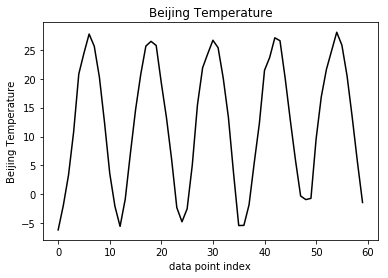

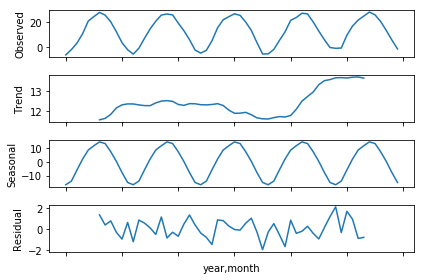

DEBUG::the size of test is:
(12,)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=148.322, BIC=151.432, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=145.034, BIC=151.255, Fit time=0.198 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=148.863, BIC=153.529, Fit time=0.043 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=136.595, BIC=144.371, Fit time=0.952 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=137.590, BIC=143.812, Fit time=0.390 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=134.625, BIC=143.957, Fit time=0.798 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=

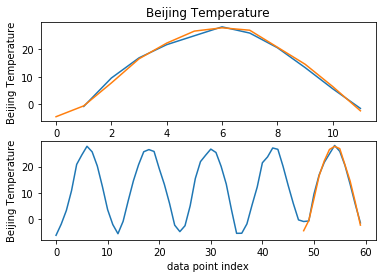

In [36]:
# plots and forecasting for Beijing weather data
plot_data(data_temp, "Beijing Temperature")
plot_seasonal(data_temp, 12)
# use 80% of data as training data
train_split = int(.8 * len(data_temp))
train = data_temp[:train_split]
test = data_temp[train_split:]
future_forecast_temp = future_forecast(train, test, True, 12)
plot_future_forecast(data_temp, test, future_forecast_temp, 'Beijing Temperature')

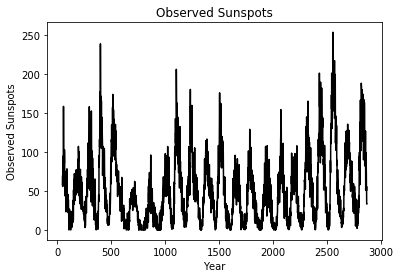

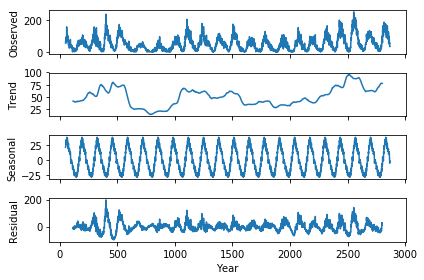

DEBUG::the size of test is:
(288,)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 132); AIC=20369.941, BIC=20404.638, Fit time=5098.359 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 132); AIC=21950.953, BIC=21962.519, Fit time=54.611 seconds


MemoryError: 

In [8]:
# plots and forecasting for sunspot data
from sklearn.metrics import mean_squared_error
import math
plot_data(data_sun, "Observed Sunspots")

# The solar cycle, which determines the number of observed sunspots has a period of 11 years
# (https://en.wikipedia.org/wiki/Solar_cycle). Therefore itps frequency (and its period for 
# seasonal differencing) is 11 years

# CONCLUSION -> period of seasonal differencing is very important, it's important for user to understand the
# periodicity of their time series for good prediction
plot_seasonal(data_sun, 132)

# use same training / testing splits as D3M prediction problem
train = data_sun[:2532]
test = data_sun[2532:]
future_forecast_sun = future_forecast(train, test, True, 132)
plot_future_forecast(data_sun, test, future_forecast_sun, 'Observed Sunspots')
print("Root Mean Squared Error = ", math.sqrt(mean_squared_error(test.values, future_forecast_sun)))
print("MIT RMSE = 30.9789")